In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
import os
from subprocess import Popen, PIPE

In [2]:
# binary with the print dots project
dots_bin = '../../examples/97_detect_dots/97_detect_dots'

# input image
img = cv2.imread('./20181027200059_IMG_20181027_195613.jpg')
#img = cv2.imread('IMG_20181027_195615.jpg')

# temporary output image
out_fn = '/tmp/tmpimgcvdots.png'

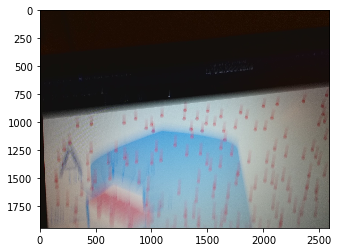

In [3]:
# showing input
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
# obtaining HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

In [5]:
# printing HSV range
print np.max(np.max(hsv, axis = 0), axis = 0)
print np.min(np.min(hsv, axis = 0), axis = 0)

[179 255 230]
[ 0  0 13]


In [6]:
# Target HSV threshold
# H: -10,10 (from 180)
# S: 100, 255 (from 255)
# V: 50,255 (from 255)

In [7]:
# obtaining hsv channels
h = hsv[:,:,0]
s = hsv[:,:,1]
v = hsv[:,:,2]

In [8]:
# doing thresholding
h_mask = (h <= 25) | (h >= 160)
s_mask = (s >= 50)
v_mask = (v >= 100)
mask = h_mask & s_mask & v_mask

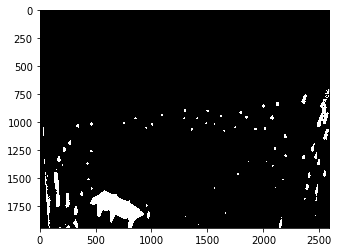

In [9]:
# plotting the image
plt.imshow(1. * mask, cmap = 'gray')
plt.show()

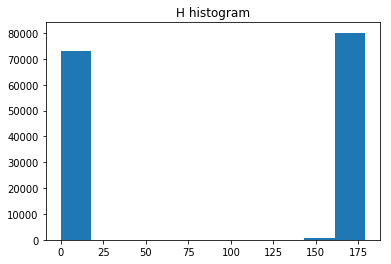

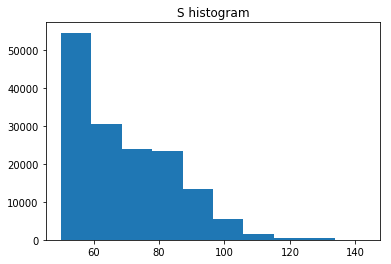

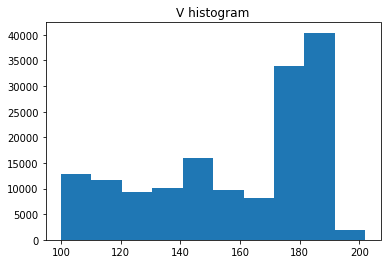

In [10]:
# plotting histograms for H, S, V
fields = 'HSV'
for i in range(3):
    plt.figure()
    plt.title('%s histogram' % fields[i])
    plt.hist(hsv[mask][:,i])
    plt.show()

In [11]:
# writing binarized image
cv2.imwrite(out_fn, 1. * mask)

True

In [12]:
def get_dots(in_fn):
    """ Run the 97_detect_dots project and output the detected dots """
    
    # run the executable
    p = Popen([dots_bin], stdin=PIPE, stdout=PIPE)
    
    # send the input data and get the output
    # TODO: reuse same process to save init time
    data = p.communicate(os.linesep.join([in_fn, 'exit']))[0]
    
    # obtaining dots as array
    data = data.split('\n')[1:-1]
    data = [x.split() for x in data]
    data = [[float(z) for z in x] for x in data]
    
    # return the array with dots
    return data

In [13]:
# get dots on thresholded image
data = get_dots(out_fn)

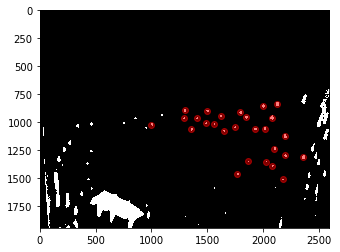

In [14]:
# plot dots on the thresholded image
plt.figure()
plt.imshow(mask, cmap = 'gray')
plt.scatter(*zip(*data), alpha = 0.5, c = 'red')
plt.show()